<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2024notebooks/2024_1011Karapetian_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Karapetian+ (2023), Empirically Identifying and Computationally Modeling the Brain–Behavior Relationship for Human Scene Categorization, Journal of Cognitive Neuroscience 35:11, pp. 1879–1897, doi:10.1162/jocn_a_02043

データは，https://osf.io/4fdky/ より入手して，駒澤 Gdrive で共有

In [ ]:
import torch
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

import numpy as np
import os
import sys
import zipfile
import glob
import PIL
import matplotlib.pyplot as plt

if isColab:
    from google.colab import drive
    drive.mount('/content/drive')

    basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian_Stimuli'
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))
else:
    HOME = os.environ['HOME']
    basedir = os.path.join(HOME, 'study/2024Agnessa14_Perceptual-decision-making.git/Stimuli')
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))

#!ls -lht '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/2023Karapetian_Stimuli'

# 刺激画像の表示

In [ ]:
# 刺激画像の表示
nrows, ncols = 12, 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,28))

i=0
for row in range(nrows):
    for col in range(ncols):
        #img = PIL.Image.open(fnames[i]).convert('RGB')
        img = PIL.Image.open(os.path.join(basedir, str(i+1)+'.jpg')).convert('RGB')
        ax[row][col].imshow(img)
        ax[row][col].axis('off')
        ax[row][col].set_title(f'{i+1}')
        i += 1

# 画像の相関係数行列を可視化


In [ ]:
# 画像を相関係数行列として可視化
import seaborn
Imgs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, str(i)+'.jpg'))
    x = np.array(img)
    Imgs.append(x.reshape(-1))

R_img = np.corrcoef(np.array(Imgs))
cmap = 'seismic'
ax = plt.axes()
seaborn.heatmap(R_img, ax=ax, cmap=cmap)
ax.set_title('生データ')
plt.show()
#seaborn.heatmap(R_img, cmap='seismic')

# 深層学習モデルの出力を相関係数行列として可視化


In [ ]:
# 深層学習モデルの出力を相関係数行列として可視化
import torchvision.models as models
from torchvision import transforms

Img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

model = models.resnet18(weights="DEFAULT") # .double()

model.eval()
outputs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, str(i)+'.jpg')).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])

R_out = np.corrcoef(np.array(outputs))

cmap = 'seismic'
ax = plt.axes()
seaborn.heatmap(R_out, ax=ax, cmap=cmap)
ax.set_title('ResNet 出力')
plt.show()

# 深層モデルの詳細

In [ ]:
print(model.eval())
print(f'model.layer4:{model.layer4}')
print(f'model.avgpool:{model.avgpool}')
print(f'model.fc:{model.fc}')

# 深層学習モデルの各層の出力を取得

In [ ]:
model = models.resnet18(weights="DEFAULT") # .double()
model = models.resnet50(weights="DEFAULT") # .double()

_avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
l1_data = []
def get_layer1_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l1_data.append(tmp.reshape(-1))

l2_data = []
def get_layer2_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l2_data.append(tmp.reshape(-1))

l4_data = []
def get_layer4_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l4_data.append(tmp.reshape(-1))

l3_data = []
def get_layer3_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l3_data.append(tmp.reshape(-1))


fc_data = []
def get_fc_output(module, input, output):
    fc_data.append(output.data.detach().cpu().numpy()[0])

#features = ['layer4', 'fc']
model.fc.register_forward_hook(get_fc_output)
model.layer1.register_forward_hook(get_layer1_output)
model.layer2.register_forward_hook(get_layer2_output)
model.layer3.register_forward_hook(get_layer3_output)
model.layer4.register_forward_hook(get_layer4_output)

model.eval()
outputs = []
for i in range(1,61):
    img = PIL.Image.open(os.path.join(basedir, str(i)+'.jpg')).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])


print(len(fc_data), np.array(fc_data).shape)
R_L1 = np.corrcoef(np.array(l1_data))
R_L2 = np.corrcoef(np.array(l2_data))
R_L3 = np.corrcoef(np.array(l3_data))
R_L4 = np.corrcoef(np.array(l4_data))
R_fc = np.corrcoef(np.array(fc_data))

# 各層の出力を可視化

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
i, row, col = 0, 0, 0
for _title, _R in [('Row', R_img), ('Layer 1', R_L1), ('Layer 2', R_L2),
                   ('Layer 3', R_L3), ('Layer 4', R_L4), ('fc', R_fc)]:
    seaborn.heatmap(_R, cmap='seismic', ax=axes[row][col])
    axes[row][col].set_title(_title)

    col += 1
    if col > 2:
        col = 0
        row += 1

plt.show()

# 機械学習モデルによりカテゴリ識別

In [ ]:
import numpy as np
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 教師信号の作成
Tch = np.array([1 for i in range(30)] + [0 for i in range(30)])
models = [KMeans(), LDA(), SVC(), LogReg()]
for model in models:
    print(model.__doc__.split('\n')[:2])
    for D in [Imgs, l1_data, l2_data, l3_data, l4_data]:
        _X, _y = np.array(D), Tch
        _X, _test, _y, _test_y = train_test_split(_X, Tch, test_size=0.2)
        model.fit(_X, _y)
        print(f'予測:{model.predict(_test)}',
              f'正解:{_test_y}')

# 機械学習モデルによるデータの可視化 (主成分分析 PCA)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = ['r','g', 'b', 'c', 'm', 'y']
fontsize=12
i, row, col = 0, 0, 0
for _title, D in [('Row', Imgs), ('Layer 1', l1_data), ('Layer 2', l2_data),
                   ('Layer 3', l3_data), ('Layer 4', l4_data), ('fc', fc_data)]:
    pca = PCA(n_components=2)
    A = pca.fit(np.array(D))
    A2 = pca.transform(D)
    for idx, z in enumerate(A2):
        color = colors[int(idx / 10)]
        axes[row][col].scatter(z[0], z[1], c=color)
        axes[row][col].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
    axes[row][col].set_title(_title)

    col += 1
    if col > 2:
        col = 0
        row += 1


# 機械学習モデルによるデータの可視化 (tSNE)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
colors = ['r','g', 'b', 'c', 'm', 'y']
fontsize=12
row, col = 0, 0
for _title, D in [('Row', Imgs), ('Layer 1', l1_data), ('Layer 2', l2_data),
                   ('Layer 3', l3_data), ('Layer 4', l4_data), ('fc', fc_data)]:

    A2 = TSNE().fit_transform(np.array(D))
    for idx, z in enumerate(A2):
        color = colors[int(idx / 10)]
        axes[row][col].scatter(z[0], z[1], c=color)
        axes[row][col].annotate(str(idx+1), (z[0], z[1]), ha='center', fontsize=fontsize, c=color)
    axes[row][col].set_title(_title)
    col += 1
    if col > 2:
        col = 0
        row += 1


# Cichy 92 データによる上記データの再現

In [ ]:
if isColab:
    basedir = '/content/drive/Shareddrives/#2024認知心理学研究(1)b/浅川先生/cichy_92'
    fnames = list(sorted(glob.glob(os.path.join(basedir,'*.jpg'))))
else:
    HOME = os.environ['HOME']
    fnames = list(sorted(glob.glob(os.path.join(HOME,'study/2024econet/data/input_image_sets/cichy_92/*.jpg'))))
fig, ax = plt.subplots(nrows=16, ncols=6, figsize=(8, 28))
i = 0
Imgs2 = []
for row in range(16):
    for col in range(6):
        img = PIL.Image.open(fnames[i]).convert('RGB')
        Imgs2.append(np.array(img))
        ax[row][col].imshow(img)
        ax[row][col].axis('off')
        ax[row][col].set_title(f'{i+1}')
        i += 1
        if i >= 92:
            break

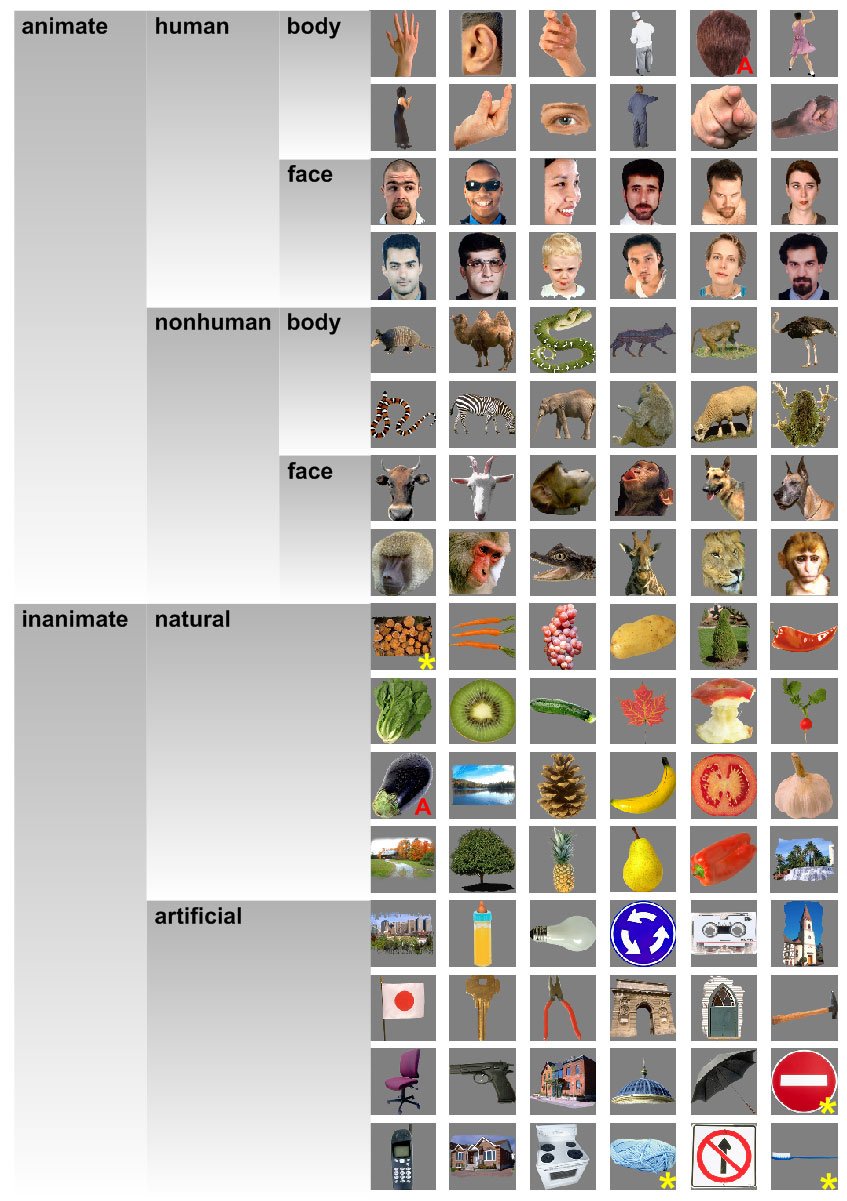

Fig. S1. Stimuli. <br/>
サルと人間に提示された物体画像。
黄色い星印のついた 4 画像は，サル実験のデータが不十分であったため，分析から除外された。
残りの 92 反応が，すべての分析の基礎となる。
被験者のうち数名が，デブリーフィング中に 2 つの刺激を曖昧であると表現した。
これらの 2 つの刺激（ナス，人間の頭の後ろ）は、赤い「A」でマークされている。<br/>

Kriegeskorte+(2008) Matching Categorical Object Representations in Inferior Temporal Cortex of Man and Monkey, DOI 10.1016/j.neuron.2008.10.043

In [ ]:
N = np.array(Imgs2).shape[0]
R_img2 = np.corrcoef(np.array(Imgs2).reshape(N,-1))
cmap = 'seismic'
ax = plt.axes()
seaborn.heatmap(R_img2, ax=ax, cmap=cmap)
ax.set_title('生データ')
plt.show()

In [ ]:
# 深層学習モデルの出力を相関係数行列として可視化
import torchvision.models as models
from torchvision import transforms

Img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

model = models.resnet18(weights="DEFAULT") # .double()

model.eval()
outputs = []
for i in range(92):
    img = PIL.Image.open(fnames[i]).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])

R_out = np.corrcoef(np.array(outputs))

cmap = 'seismic'
ax = plt.axes()
seaborn.heatmap(R_out, ax=ax, cmap=cmap)
ax.set_title('ResNet 出力')
plt.show()

In [ ]:
model = models.resnet18(weights="DEFAULT") # .double()
model = models.resnet50(weights="DEFAULT") # .double()

_avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
l1_data = []
def get_layer1_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l1_data.append(tmp.reshape(-1))

l2_data = []
def get_layer2_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l2_data.append(tmp.reshape(-1))

l4_data = []
def get_layer4_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l4_data.append(tmp.reshape(-1))

l3_data = []
def get_layer3_output(module, input, output):
    tmp = _avgpool(output.data)
    tmp = tmp.detach().cpu().numpy()
    l3_data.append(tmp.reshape(-1))


fc_data = []
def get_fc_output(module, input, output):
    fc_data.append(output.data.detach().cpu().numpy()[0])

model.fc.register_forward_hook(get_fc_output)
model.layer1.register_forward_hook(get_layer1_output)
model.layer2.register_forward_hook(get_layer2_output)
model.layer3.register_forward_hook(get_layer3_output)
model.layer4.register_forward_hook(get_layer4_output)

model.eval()
outputs = []
for i in range(len(fnames)):
    img = PIL.Image.open(fnames[i]).convert('RGB')
    _img = Img_transform(img)
    out = model(_img.unsqueeze(0))
    outputs.append(out.detach().numpy()[0])


print(len(fc_data), np.array(fc_data).shape)
R_L1 = np.corrcoef(np.array(l1_data))
R_L2 = np.corrcoef(np.array(l2_data))
R_L3 = np.corrcoef(np.array(l3_data))
R_L4 = np.corrcoef(np.array(l4_data))
R_fc = np.corrcoef(np.array(fc_data))

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
i, row, col = 0, 0, 0
for _title, _R in [('Row', R_img), ('Layer 1', R_L1), ('Layer 2', R_L2),
                   ('Layer 3', R_L3), ('Layer 4', R_L4), ('fc', R_fc)]:
    seaborn.heatmap(_R, cmap='seismic', ax=axes[row][col])
    axes[row][col].set_title(_title)

    col += 1
    if col > 2:
        col = 0
        row += 1

plt.show()

In [ ]:
import numpy as np
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 教師信号の作成
# Tch = np.array([1 for i in range(24)]
#                + [2 for i in range(24)]
#                + [3 for i in range(24)]
#                + [4 for i in range(20)])
Tch = np.array([0 for i in range(48)] + [1 for i in range(44)])

#models = [SVC(), LogReg()]
models = [KMeans(), LDA(), SVC(), LogReg()]
for model in models:
    print(model.__doc__.split('\n')[:2])
    for D in [Imgs2, l1_data, l2_data, l3_data, l4_data]:
        _X, _y = np.array(D).reshape(92,-1), Tch
        _X, _test, _y, _test_y = train_test_split(_X, Tch, test_size=0.2)
        model.fit(_X, _y)
        print(f'予測:{model.predict(_test)}',
              f'正解:{_test_y}')